# Simulating yield surfaces with DAMASK simulations

This Jupyter notebook processes the results from the demo workflow `simulate_yield_surface_2D`, and generates a plot of yield surfaces for a range of known-textures (e.g. Cube, Goss, etc.).

In [1]:
from collections import defaultdict

import numpy as np
from IPython.display import Image
from plotly.subplots import make_subplots
from plotly.graph_objects import FigureWidget

import matflow as mf

## Utility functions

In [2]:
def get_hydrostatic_tensor(tensor):
    """Returns the hydrostatic tensor from an input stress strain tensor

    Parameters
    ----------
    tensor : ndarray of shape array (..., 3, 3)

    Returns
    -------
    (..., 3, 3) array hydrostatic stress on the diagonal of tensor with 0 in shear values

    """

    hydro = np.zeros_like(tensor)
    hydro[..., [0, 1, 2], [0, 1, 2]] = (np.trace(tensor, axis1=-2, axis2=-1) / 3)[
        ..., None
    ]
    return hydro


def get_von_mises(s, tensor):
    """Returns the equivalent value of stress or strain tensor

    Parameters
    ----------
    tensor : ndarray of shape (..., 3, 3)
        Tensor of which to get the von Mises equivalent.
    s : float
        Scaling factor: 3/2 for stress, 2/3 for strain.

    Returns
    -------
    Von Mises equivalent value of tensor.

    """

    deviatoric = tensor - get_hydrostatic_tensor(tensor)

    return np.sqrt(s * np.sum(deviatoric**2.0, axis=(-2, -1)))


def get_von_mises_stress(stress):
    return get_von_mises(3 / 2, stress)


def get_von_mises_strain(strain):
    return get_von_mises(2 / 3, strain)


def order_coplanar_points(points, normal, anticlockwise=True):
    """
    Find the clockwise or anticlockwise ordering of a set of coplanar 3D points.

    Parameters
    ----------
    points : ndarray of shape (3, N)
        The set of coplanar points (three-vector columns) whose ordering is to be found.
    normal : ndarray of shape (3, 1)
        Column three-vector representing the normal of the plane on which all points lie.

    Returns
    -------
    Ordered indices of points according to a clockwise or anticlockwise direction when
    looking in the opposite direction to `normal`.

    """

    # Normalise `normal` to a unit vector:
    normal = normal / np.linalg.norm(normal)

    # Compute the centroid:
    centroid = np.mean(points, axis=1)

    # Get the direction vectors from each point to the centroid
    p = points - centroid[:, np.newaxis]

    # Use the first point as the reference point
    # Find cross product of each point with the reference point
    crs = np.cross(p[:, 0:1], p, axis=0)

    # Find the scalar triple product of the point pairs and the normal vector
    stp = np.einsum("ij,ik->k", normal, crs)

    # Find the dot product of the point pairs
    dot = np.einsum("ij,ik->k", p[:, 0:1], p)

    # Find signed angles from reference point to each other point
    ang = np.arctan2(stp, dot)
    ang_order = np.argsort(ang)

    if not anticlockwise:
        ang_order = ang_order[::-1]

    return ang_order

## Processing functions

In [3]:
def group_elements_by_texture(workflow, err_ids=None):
    """Group elements by the RVE texture."""
    # TODO: speed up this sort of scenario (upstream dependencies inputs/ouputs
    # retrieval; and could cache all elements first)
    sim_elems_by_ori = defaultdict(list)
    for elem in workflow.tasks.simulate_VE_loading_damask.elements:
        if elem.index in (err_ids or []):
            continue

        gen_VE_elem = [
            i
            for i in elem.get_element_dependencies(as_objects=True)
            if i.task.name == "generate_volume_element_from_voronoi"
        ][0]

        sample_texture_elem = [
            i
            for i in gen_VE_elem.get_element_dependencies(as_objects=True)
            if i.task.name == "sample_texture_from_model_ODF_mtex"
        ][0]

        modal_ori_euler = sample_texture_elem.inputs.ODF_components.value[0][
            "modal_orientation_euler"
        ]

        sim_elems_by_ori[tuple(modal_ori_euler)].append(elem)

    return sim_elems_by_ori


def get_stress_at_yield(VE_response, criterion=0.002):
    stress = VE_response.value["phase_data"]["vol_avg_stress"]["data"][:]
    plastic_strain = VE_response.value["phase_data"]["vol_avg_plastic_strain"]["data"][
        :
    ]

    plastic_strain_vM = get_von_mises_strain(plastic_strain)
    yield_idx = (np.abs(plastic_strain_vM - criterion)).argmin()
    stress_at_yield = stress[yield_idx]

    return stress_at_yield


def get_yield_tensors(sim_elements, criterion=0.002):
    yield_tensors = np.array(
        [get_stress_at_yield(i.outputs.VE_response, criterion) for i in sim_elements]
    )

    # find where y-stress is closest to zero:
    eq_stress_idx = np.abs(yield_tensors[:, 1, 1]).argmin()
    eq_stress = np.abs(yield_tensors[eq_stress_idx, 0, 0])

    # normalise by equivalent stress:
    yield_tensors = yield_tensors / eq_stress

    return yield_tensors


def plot_yield_surfaces(sim_elems_by_ori, texture_eulers):

    nsubplots = len(sim_elems_by_ori)
    ncols = 2
    nrows = int(np.ceil(nsubplots / ncols))

    fig = make_subplots(
        rows=nrows,
        cols=ncols,
        subplot_titles=list(texture_eulers),
        vertical_spacing=0.12,
        horizontal_spacing=0.2,
    )
    fig.update_layout(
        height=300 * nrows,
        width=300 * ncols,
        showlegend=False,
        template="seaborn",
        title_text="Known-texture yield surfaces from DAMASK simulations",
    )

    for i in range(1, nsubplots + 1):
        fig.layout[f"yaxis{i}"].update(
            scaleanchor=f"x{i}",
            scaleratio=1,
            range=[-2.1, 2.1],
            title="σ<sub>TD</sub> / σ<sub>eq.</sub>",
        )
        fig.layout[f"xaxis{i}"].update(
            title="σ<sub>RD</sub> / σ<sub>eq.</sub>",
        )

    for idx, (text_name, eulers) in enumerate(texture_eulers.items()):
        elems = sim_elems_by_ori[eulers]
        yield_tensors = get_yield_tensors(elems)

        x = yield_tensors[:, 0, 0]
        y = yield_tensors[:, 1, 1]
        xy0 = np.array([x, y, np.zeros_like(x)])

        order_idx = order_coplanar_points(xy0, np.array([0, 0, 1])[:, None])
        order_idx = np.concatenate((order_idx, order_idx[0:1]))  # close the loop

        x = x[order_idx]
        y = y[order_idx]

        fig.add_scatter(x=x, y=y, row=(idx // 2) + 1, col=(idx % 2) + 1)

    return fig

## Load and process simulations

In [4]:
TEXTURE_EULERS = {
    "Copper": (90, 35, 45),
    "S": (59, 37, 63),
    "Goss": (0, 45, 90),
    "Brass": (35, 45, 90),
    "Cube": (0, 0, 0),
}

wk = mf.Workflow(r"/path/to/simulate_yield_surface_2D/workflow")

# simulate task element indices that failed
err_ids = (19,)  # 19: out of memory

In [5]:
sim_elems_by_ori = group_elements_by_texture(workflow=wk, err_ids=err_ids) # ~ 1 min runtime

## Plot yield surfaces

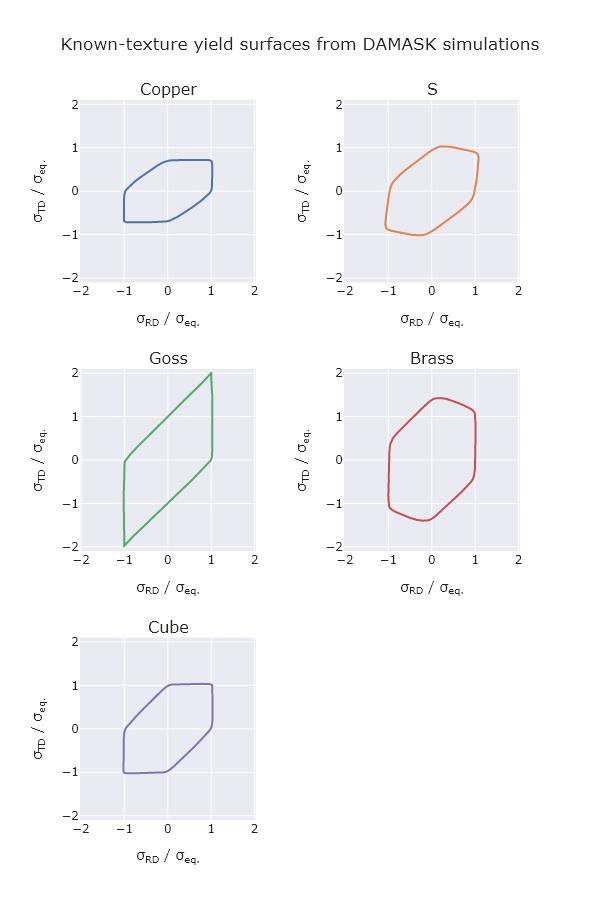

In [12]:
fig = plot_yield_surfaces(sim_elems_by_ori, TEXTURE_EULERS)
fig.write_image("yield_surfaces.png")
Image("yield_surfaces.png")